In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import geopandas as gpd
from glob import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

sys.path.insert(1,'../analysis/')
sys.path.insert(1,'../optimization/')
from results_plotting import *
import plant_optimization as pop

In [3]:
results_paths = '../../results/plant_optimization/final_results'

# Import grid
europe_grid, europe_borders = load_base_maps()
europe_grid = europe_grid[['lat','lon','country','sea_node','geometry']]
merge_cols = list(europe_grid.columns)
merge_cols.remove('geometry')

# Import 2020 results
year = '2020'
data_2020 = pd.read_csv(os.path.join(results_paths,f'{year}.csv'))
data_2020_geo = gpd.GeoDataFrame(data_2020.drop(columns=['geometry'])).merge(europe_grid,on=merge_cols,how='left')
countries = data_2020.country.unique()

In [4]:
data_2020_geo

,lat,lon,shore_designation,wind_capacity_MW,wind_turbines,rated_turbine_power,rotor_diameter,turbine_type,wind_class,PV_capacity_MW,...,pt_in_sea,coast_pt,cent_lat,cent_lon,merra_lat,merra_lon,shore_dist,pv_lat,pv_lon,geometry
0,48.5,16.875,onshore,12.00,5.0,2400.0,117.0,N117/2400,lo,18.073167,...,0,0,48.499518,16.732534,48.5,16.875,0.000000,48.499518,16.732534,"POLYGON ((16.56250 48.75000, 16.70675 48.75000..."
1,49.0,16.875,onshore,12.50,5.0,2500.0,120.0,GE120/2500,lo,14.575609,...,0,0,48.771704,16.617665,49.0,16.875,0.000000,48.771704,16.617665,"POLYGON ((16.70675 48.75000, 16.56250 48.75000..."
2,47.0,9.375,onshore,29.70,9.0,3300.0,131.0,N131/3300,lo,53.957385,...,0,0,47.164853,9.645249,47.0,9.375,0.000000,47.164853,9.645249,"POLYGON ((9.55984 47.25000, 9.68750 47.25000, ..."
3,47.5,9.375,onshore,16.50,5.0,3300.0,131.0,N131/3300,lo,41.449873,...,0,0,47.377633,9.631662,47.5,9.375,0.946927,47.377633,9.631662,"POLYGON ((9.68750 47.52951, 9.68750 47.25000, ..."
4,47.0,10.000,onshore,29.70,9.0,3300.0,131.0,N131/3300,lo,49.986112,...,0,0,47.082648,10.034669,47.0,10.000,0.000000,47.082648,10.034669,"POLYGON ((9.68750 47.25000, 10.31250 47.25000,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5376,51.5,1.250,offshore,18.99,3.0,6330.0,152.0,S152/6330,monopole,0.000000,...,1,1,51.562154,1.293134,51.5,1.250,19.831921,NaN,NaN,"POLYGON ((1.21491 51.75000, 1.56250 51.75000, ..."
5377,52.0,1.250,offshore,18.99,3.0,6330.0,152.0,S152/6330,monopole,0.000000,...,0,1,51.842593,1.452518,52.0,1.875,11.513362,NaN,NaN,"POLYGON ((1.56250 52.00595, 1.56250 51.75000, ..."
5378,53.0,1.250,offshore,18.99,3.0,6330.0,152.0,S152/6330,monopole,0.000000,...,1,1,53.103762,1.271155,53.0,1.250,19.129110,NaN,NaN,"POLYGON ((0.93750 53.25000, 1.56250 53.25000, ..."
5379,53.5,1.250,offshore,18.99,3.0,6330.0,152.0,S152/6330,floating,0.000000,...,1,0,53.500000,1.250000,53.5,1.250,62.511349,NaN,NaN,"POLYGON ((0.93750 53.75000, 1.56250 53.75000, ..."


# PV resources

In [43]:
filenames = os.listdir('../../results/PV_power_output/')

geo_joiner = data_2020_geo[['lat','lon','country','shore_designation','geometry']].copy()
PV_geo = []
for filename in filenames:
    pv_data = pd.read_parquet(os.path.join('../../results/PV_power_output',filename))
    pv_data = pv_data[['Wh']].groupby(['lat','lon']).sum()
    pv_data['kWh_per_kW'] = pv_data['Wh']/1e3
    pv_data['country'] = filename.replace('_PV.parquet.gzip','')
    pv_data['shore_designation'] = 'onshore'
    pv_data = pv_data.reset_index(drop=False)
    
    PV_geo.append(pd.merge(geo_joiner, pv_data[['lat','lon','country','shore_designation','kWh_per_kW']], on=['lat','lon','country','shore_designation']))
#     break
PV_geo_df = pd.concat(PV_geo)

/opt/anaconda3/envs/EuroSAFs/lib/python3.7/site-packages/fastparquet/core.py:278: UserWarning: Non-categorical multi-index is likely brittle
  warnings.warn("Non-categorical multi-index is likely brittle")


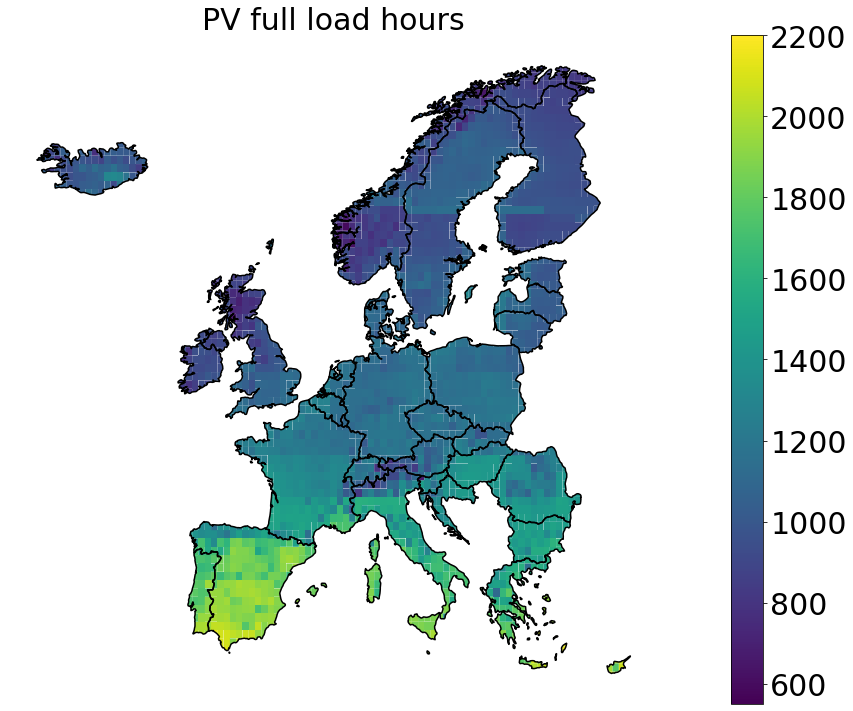

In [60]:
metrics = {'kWh_per_kW':'PV full load hours'}
vmax_dict = {'kWh_per_kW':2200}
vmin_dict = {'kWh_per_kW':550}
legend_kwds = {'orientation':'vertical'}
missing_kwds = {'color':'lightgrey'}
fontsize = 30
plot_results(data=PV_geo_df,countries=countries,metrics=metrics,vmax_dict=vmax_dict,vmin_dict=vmin_dict,missing_kwds=missing_kwds,legend_kwds=legend_kwds,cmap='viridis',figsize=(20,10),fontsize=fontsize)
plt.tight_layout()
plt.subplots_adjust(hspace=0,wspace=0.08)
plt.savefig('../../gfx/PV_potential.png',dpi=400, bbox_inches='tight')

# Installed capacities

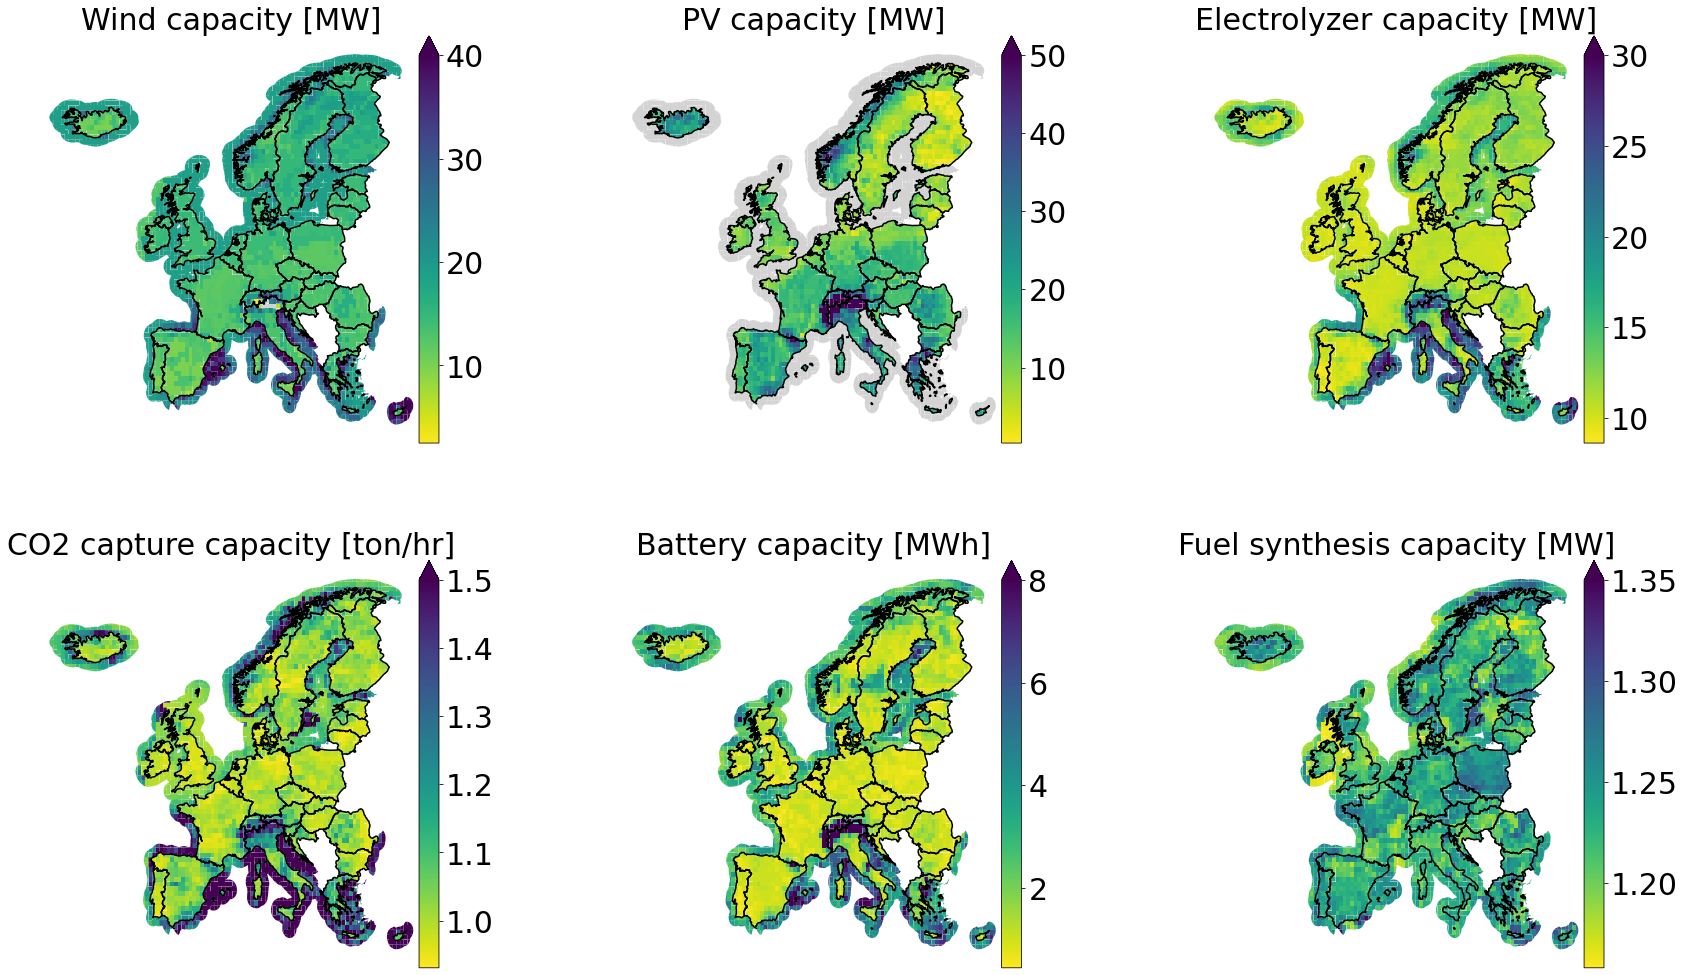

In [4]:
data = data_2020_geo.copy()
data.loc[data.battery_capacity_MWh==0,'battery_capacity_MWh'] = np.nan
data.loc[data.PV_capacity_MW==0,'PV_capacity_MW'] = np.nan
data.loc[data.wind_capacity_MW==0,'wind_capacity_MW'] = np.nan
metrics = {'wind_capacity_MW':'Wind capacity [MW]',
           'PV_capacity_MW':'PV capacity [MW]',
           'electrolyzer_capacity_MW':'Electrolyzer capacity [MW]',
           'CO2_capture_tonph':'CO2 capture capacity [ton/hr]',
           'battery_capacity_MWh':'Battery capacity [MWh]',
           'H2tL_capacity_MW':'Fuel synthesis capacity [MW]'}
vmax_dict = {'wind_capacity_MW':40,#35,
             'PV_capacity_MW':50,#35,
             'electrolyzer_capacity_MW':30,#35,
             'CO2_capture_tonph':1.5,#3,
             'battery_capacity_MWh':8,#5,
             'H2tL_capacity_MW':1.35}#1.45}
legend_kwds = {'extend':'max','orientation':'vertical'}
missing_kwds = {'color':'lightgrey'}
fontsize = 30
plot_results(data=data,countries=countries,metrics=metrics,vmax_dict=vmax_dict,missing_kwds=missing_kwds,legend_kwds=legend_kwds,cmap='viridis_r',figsize=(25,15),fontsize=fontsize)
plt.tight_layout()
plt.subplots_adjust(hspace=0,wspace=0.08)
plt.savefig('../../gfx/component_capacities.png',dpi=400)

# PV vs wind capacities

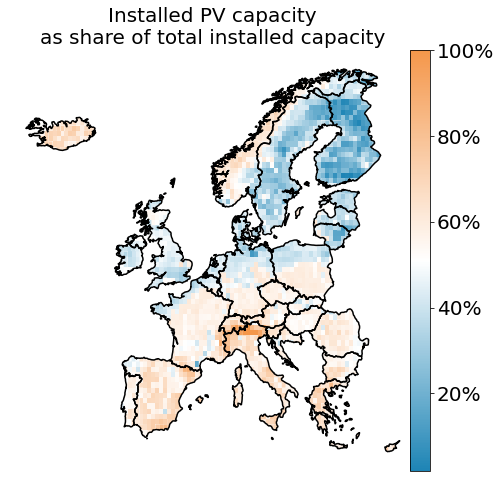

In [5]:
data = data_2020_geo.copy()
data = data.loc[data.shore_designation=='onshore']
data = data[['wind_capacity_MW','PV_capacity_MW','country','geometry','LCOF_liter']]
data['pv_share'] = data['PV_capacity_MW']/ (data['PV_capacity_MW'] + data['wind_capacity_MW'])


metrics = {'pv_share':'Installed PV capacity\nas share of total installed capacity'}

legend_kwds = {'orientation':'vertical'}

cmap = LinearSegmentedColormap.from_list('test',['#1D84B5','white','#F4974B'])

fontsize = 20

fig, axes, cb_ax = plot_results(data=data,countries=countries,metrics=metrics,legend_kwds=legend_kwds,cmap=cmap,figsize=(10,10),fontsize=fontsize)

ticks = cb_ax.get_yticks()
cb_ax.yaxis.set_ticks(ticks)
cb_ax.set_yticklabels([f'{x*100:.0f}%' for x in ticks]);

plt.savefig('../../gfx/pv_share_map.png', bbox_inches='tight', dpi=400)

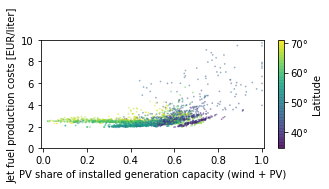

In [8]:
data = data_2020_geo.copy()
data = data.loc[data.shore_designation=='onshore']
data = data[['lat','lon','wind_capacity_MW','PV_capacity_MW','country','geometry','LCOF_liter']]
data['pv_share'] = data['PV_capacity_MW']/ (data['PV_capacity_MW'] + data['wind_capacity_MW'])

cmap = LinearSegmentedColormap.from_list('test',['#1D84B5','white','#F4974B'])


fig,ax = plt.subplots(figsize=(6,3))
sc = ax.scatter(data['pv_share'], data['LCOF_liter'], s=3, alpha=0.5, linewidth=0, c=data['lat'])#, cmap=cmap)
ax.set_ylim(0,10)
ax.set_xlim(-0.01,1.01)
ax.set_ylabel('Jet fuel production costs [EUR/liter]')
ax.set_xlabel('PV share of installed generation capacity (wind + PV)')

cb = plt.colorbar(sc)
cb.set_ticks(cb.get_ticks())
cb.set_ticklabels([f'{x:.0f}'+u'\N{DEGREE SIGN}' for x in cb.get_ticks()])
cb.set_label('Latitude')

plt.savefig('../../gfx/pv_share_lcof_scatter.png', bbox_inches='tight', dpi=400)

# Curtailment

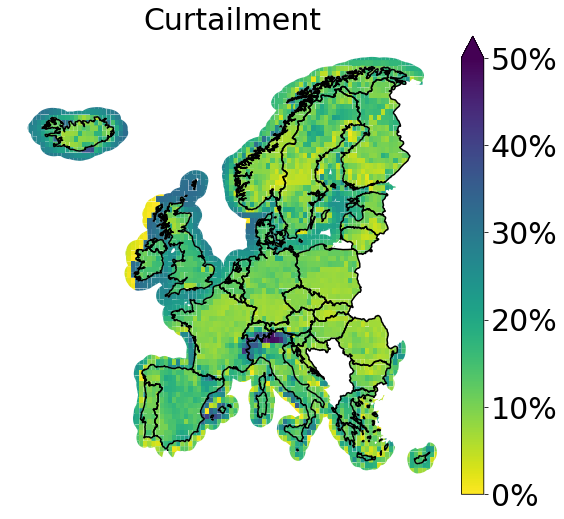

In [6]:
curtailment_data = data_2020_geo[['lat','lon','country','geometry','wind_production_MWh','PV_production_MWh','curtailed_el_MWh']].copy()
curtailment_data['curtailment_ratio'] = curtailment_data['curtailed_el_MWh'] / (curtailment_data['wind_production_MWh'] + curtailment_data['PV_production_MWh']) * 100
metrics = {'curtailment_ratio':'Curtailment'}
vmax_dict = {'curtailment_ratio':50}
legend_kwds = {'extend':'max','orientation':'vertical'}
fontsize = 30
fig, axes, cb_ax = plot_results(data=curtailment_data,countries=countries,metrics=metrics,vmax_dict=vmax_dict,legend_kwds=legend_kwds,figsize=(10,10),cmap='viridis_r',fontsize=fontsize)
cb_ax.yaxis.set_ticks(cb_ax.get_yticks()) # This line is only intended to supress a warning resulting from the following
cb_ax.set_yticklabels([f'{x:.0f}%' for x in cb_ax.get_yticks()])
plt.tight_layout()
plt.savefig('../../gfx/curtailment.png',dpi=400)

# Turbine types

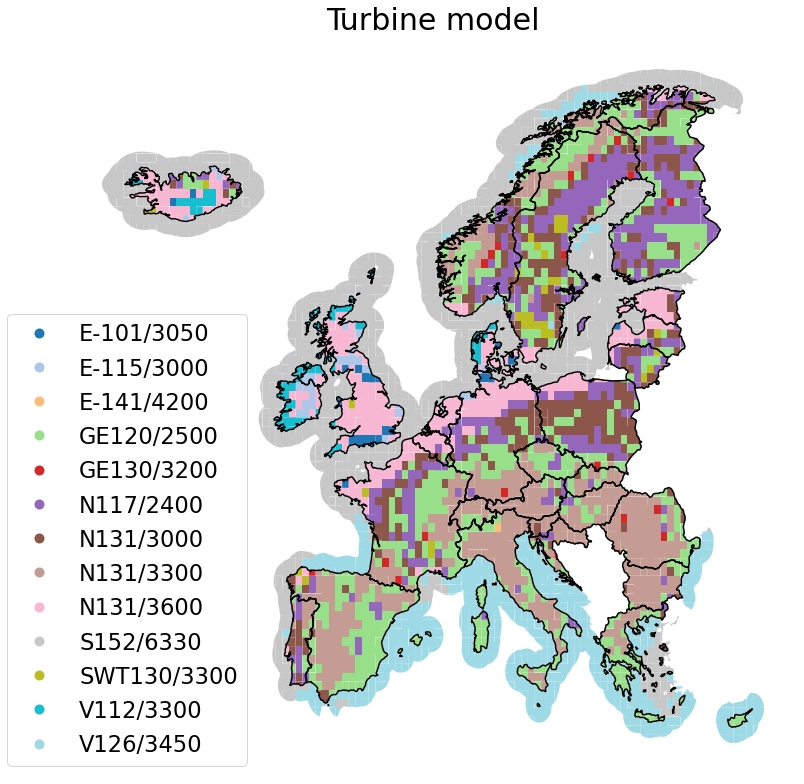

In [7]:
data = data_2020_geo.copy()
metrics = {'turbine_type':'Turbine model'}
vmax_dict = None
legend_kwds = {'loc':'lower left', 'bbox_to_anchor':(-0.1,0), 'ncol':1}
fontsize = 30
plot_results(data=data,countries=countries,metrics=metrics,legend_kwds=legend_kwds,figsize=(11,11),fontsize=fontsize)
plt.tight_layout()
plt.savefig('../../gfx/turbine_models.png',dpi=400)

# Costs

In [4]:
year=2020
costs_df = pd.read_csv(os.path.join(results_paths,f'{year}.csv'))

specs = pd.read_excel('../../data/plant_assumptions.xlsx',sheet_name='data',index_col=0)
specs_names = specs.index

specs_temp = specs.copy()
specs_temp['value'] = specs_temp[f'value_{year}']
# If any specs are not specified for the given year, take the 2020 value
specs_temp.loc[specs_temp.value.isna(),'value'] = specs_temp.loc[specs_temp.value.isna(),'value_2020']

components = {'wind':['wind_capacity_MW',1e3],
              'PV':['PV_capacity_MW',1e3],
              'battery':['battery_capacity_MWh',1e3],
              'electrolyzer':['electrolyzer_capacity_MW',1e3],
              'CO2':['CO2_capture_tonph',8760],
              'H2stor':['H2stor_capacity_MWh',1e3],
              'CO2stor':['CO2stor_capacity_ton',1],
              'H2tL':['H2tL_capacity_MW',1e3],
              'heat':['boiler_capacity_MW',1e3]}
discount_rate = specs_temp.at['discount_rate',f'value']
plant_lifetime = specs_temp.at['lifetime',f'value']

for component in components.keys():
    costs_df[component+'_NPV'] = np.nan
    costs_df[f'{component}_verify_CAPEX'] = np.nan
costs_df['verify_NPV'] = np.nan
    
for idx,row in costs_df.iterrows():
    verify_NPV = 0
    verify_CAPEX = 0
    for component,value in components.items():
        if component == 'wind':
            if row['shore_designation'] == 'onshore':
                wind_class = row['wind_class']
                capex = specs_temp.at[f'{component}_{wind_class}_CAPEX',f'value']
                opex = specs_temp.at[f'{component}_{wind_class}_OPEX',f'value']
            elif row['shore_designation'] == 'offshore':
                platform_type = 'monopole' if row['shore_dist']<=60 else 'floating'
                capex = specs_temp.at[f'{component}_{platform_type}_CAPEX',f'value']
                opex = specs_temp.at[f'{component}_{platform_type}_OPEX',f'value']
        else:
            capex = specs_temp.at[f'{component}_CAPEX',f'value']
            opex = specs_temp.at[f'{component}_OPEX',f'value']
        component_lifetime = specs_temp.at[f'{component}_lifetime',f'value']
        capacity = row[value[0]]*value[1]
        component_capex = capex * capacity
        costs_df.loc[idx,f'{component}_verify_CAPEX'] = component_capex        
        verify_CAPEX += component_capex
        
        if component == 'electrolyzer':
            component_npv = pop.costs_NPV(capex=capex,opex=opex,discount_rate=discount_rate,plant_lifetime=plant_lifetime,component_lifetime=specs_temp.at['electrolyzer_stack_lifetime',f'value'],
                                          capacity=capacity,replacement_capex_fraction=specs_temp.at['electrolyzer_stack_CAPEX',f'value'])                
        else:
            component_npv = pop.costs_NPV(capex=capex,opex=opex,discount_rate=discount_rate,plant_lifetime=plant_lifetime,component_lifetime=component_lifetime,capacity=capacity,)
        costs_df.loc[idx,component+'_NPV'] = component_npv
        verify_NPV += component_npv
    costs_df.loc[idx,'verify_NPV'] = verify_NPV
    costs_df.loc[idx,'verify_CAPEX'] = verify_CAPEX
#     if idx == 0:
#         break

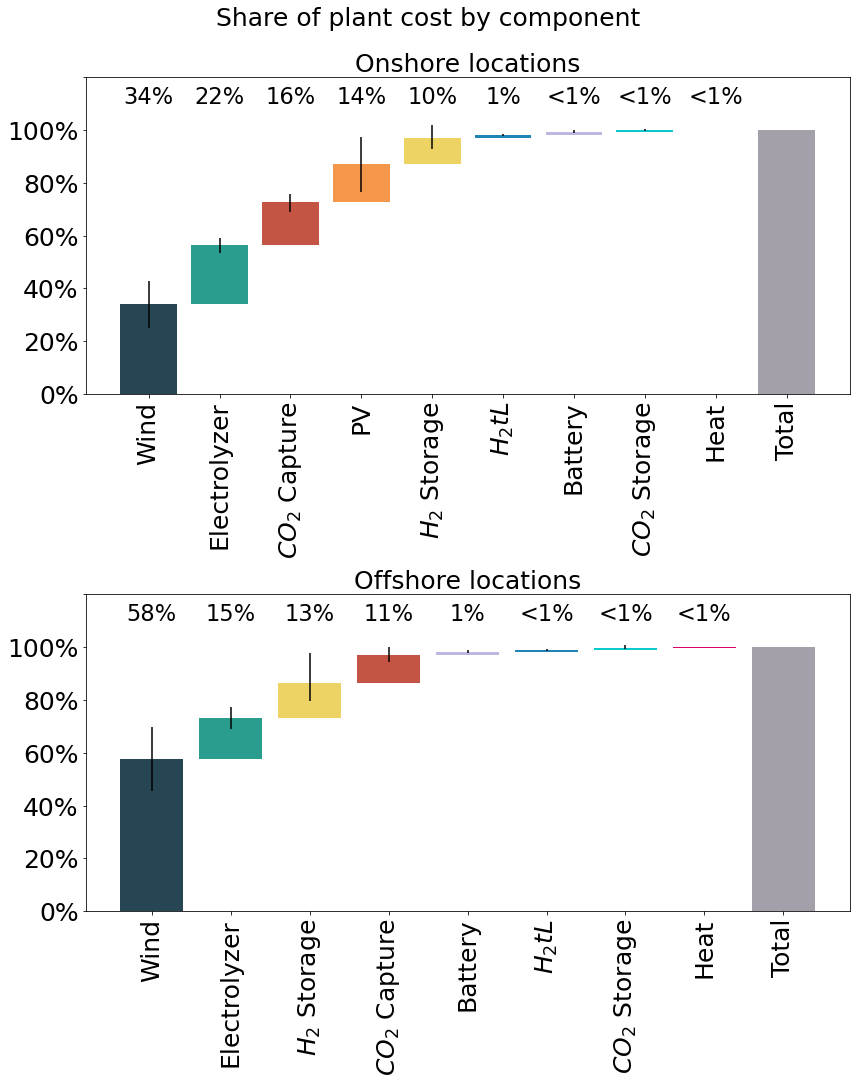

In [9]:
onshore_npv_cols = ['wind_NPV', 'electrolyzer_NPV', 'CO2_NPV', 'PV_NPV', 'H2stor_NPV', 'H2tL_NPV', 'battery_NPV', 'CO2stor_NPV', 'heat_NPV', 'verify_NPV']
offshore_npv_cols = ['wind_NPV', 'electrolyzer_NPV', 'H2stor_NPV', 'CO2_NPV', 'battery_NPV', 'H2tL_NPV', 'CO2stor_NPV', 'heat_NPV', 'verify_NPV']
colors = ['#264653','#2A9D8F','#C45544','#F4974B','#EDD363','#1D84B5','#BEB7DF','#0BC9CD','#D90368','#A4A0A9']
colormap = {x:colors[i] for i,x in enumerate(onshore_npv_cols)}

col_name_map = {
    'wind_NPV':'Wind', 
    'electrolyzer_NPV':'Electrolyzer',
    'CO2_NPV':'$CO_{2}$ Capture',
    'PV_NPV':'PV',
    'H2stor_NPV':'$H_{2}$ Storage',
    'H2tL_NPV':'$H_{2}tL$',
    'battery_NPV':'Battery',
    'CO2stor_NPV':'$CO_{2}$ Storage',
    'heat_NPV':'Heat',
    'verify_NPV':'Total'
}

fig,axes = plt.subplots(nrows=2, figsize=(12,15))
fontsize = 25

for i,shore_designation,cols in zip([0,1],['onshore','offshore'],[onshore_npv_cols,offshore_npv_cols]):
    npv_share = costs_df.loc[costs_df['shore_designation']==shore_designation,cols]
    for col in npv_share.columns:
        npv_share[col] = npv_share[col]/npv_share['verify_NPV']
    npv_share = npv_share.describe(percentiles=[0.05,0.5,0.95]).T * 100

    npv_share_cumsum = npv_share.cumsum()
    npv_share_cumsum.iloc[-1] = npv_share.iloc[-1]
    npv_share_cumsum_mask = npv_share_cumsum.shift()
    npv_share_cumsum_mask.iloc[-1] = 0



    yerr1 = npv_share['mean'] - npv_share['5%']
    yerr2 = npv_share['95%'] - npv_share['mean']
    axes[i].bar(npv_share_cumsum.index.map(col_name_map), npv_share_cumsum['mean'], yerr=[yerr1,yerr2], color=npv_share_cumsum.index.map(colormap))
    axes[i].bar(npv_share_cumsum_mask.index.map(col_name_map), npv_share_cumsum_mask['mean'], color='white')
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(90)

    for j,comp_share in enumerate(npv_share['mean'].iloc[:-1]):
        if comp_share<1:
            text = '<1%'
        else:
            text = f'{comp_share:.0f}%'
        axes[i].annotate(text, (j,110), fontsize=fontsize*0.9, ha='center')
    axes[i].tick_params(labelsize=fontsize)
    
    axes[i].set_ylim(0,118)
    axes[i].yaxis.set_ticks(axes[i].get_yticks()) # This line is only intended to supress a warning resulting from the following
    new_ticks = [f'{x:.0f}%' for x in axes[i].get_yticks()]
    new_ticks[-1] = ''
    axes[i].set_yticklabels(new_ticks)
    
axes[0].set_title('Onshore locations', fontsize=fontsize)
axes[1].set_title('Offshore locations', fontsize=fontsize)
fig.suptitle('Share of plant cost by component', y=1, fontsize=fontsize)
# plt.subplots_adjust(hspace=0,wspace=0.25)
plt.tight_layout()
plt.savefig('../../gfx/cost_share.png', bbox_inches='tight', dpi=400)

# Runtime limit

In [144]:
runtime_limit = 3000
print(len(data_2020_geo.loc[data_2020_geo.runtime>=runtime_limit]),'Points reached the runtime limit')

9 Points reached the runtime limit


10 outlier entries were dropped.


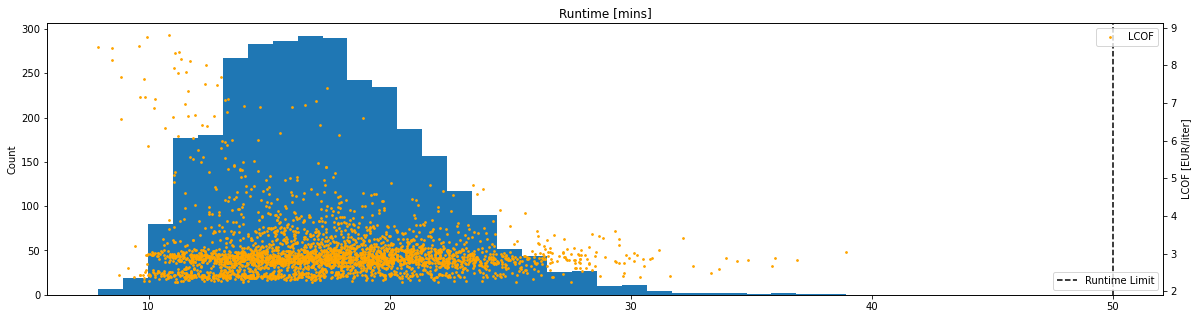

In [26]:
data = drop_outliers(data_2020_geo,z_score_filter=7)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(20,5))
ax.hist(data.runtime/60,bins=30)
ax.axvline(runtime_limit/60,c ='k',linestyle='--',label='Runtime Limit') # Runtime limit
ax2 = plt.twinx(ax)
ax2.scatter(data.runtime/60,data.LCOF_liter,color='orange',s=3,label='LCOF');
ax.set_title('Runtime [mins]')
ax2.set_ylabel('LCOF [EUR/liter]')
ax2.legend(loc='upper right')
ax.legend(loc='lower right')
ax.set_ylabel('Count');

# Distributions

10 outlier entries were dropped.


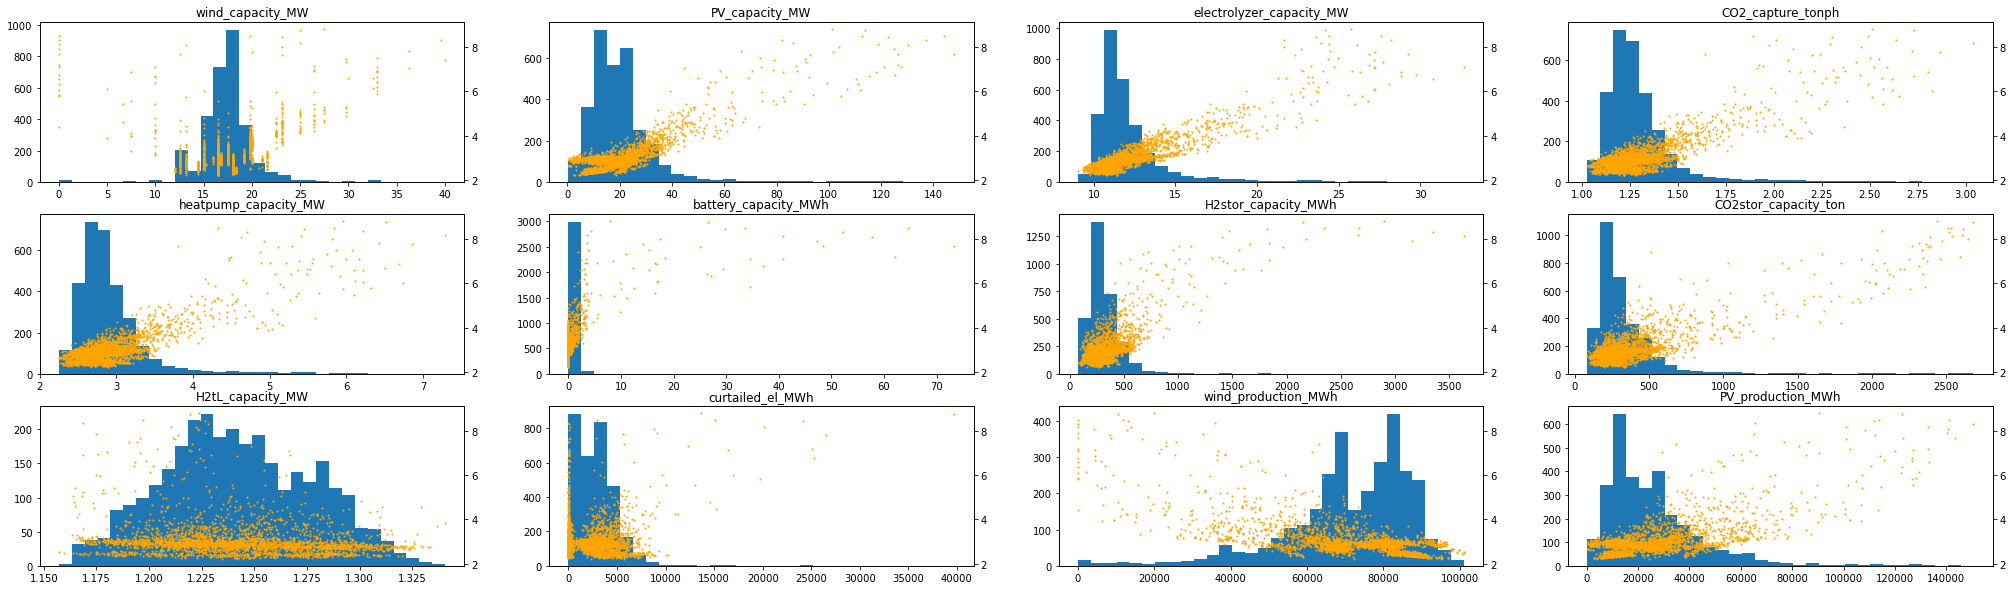

In [27]:
data = drop_outliers(data_2020_geo,z_score_filter=7)

metrics = ['wind_capacity_MW','PV_capacity_MW', 'electrolyzer_capacity_MW', 'CO2_capture_tonph',
       'heatpump_capacity_MW', 'battery_capacity_MWh', 'H2stor_capacity_MWh',
       'CO2stor_capacity_ton', 'H2tL_capacity_MW', 'curtailed_el_MWh',
       'wind_production_MWh', 'PV_production_MWh']
ncols=None
figsize=(35,10)
if ncols == None:
    ncols = int(np.ceil(np.sqrt(len(metrics))))
nrows = int(np.ceil(len(metrics)/ncols))
fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
axes = np.reshape(axes,(1,nrows*ncols))[0]
for i,metric in enumerate(metrics):
    axes[i].hist(data[metric],bins=30)
    ax2 = plt.twinx(axes[i])
    ax2.scatter(data[metric],data.LCOF_liter,s=1,color='orange')
    axes[i].set_title(metric)

# PV-Battery Relation

In [95]:
axes

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

10 outlier entries were dropped.


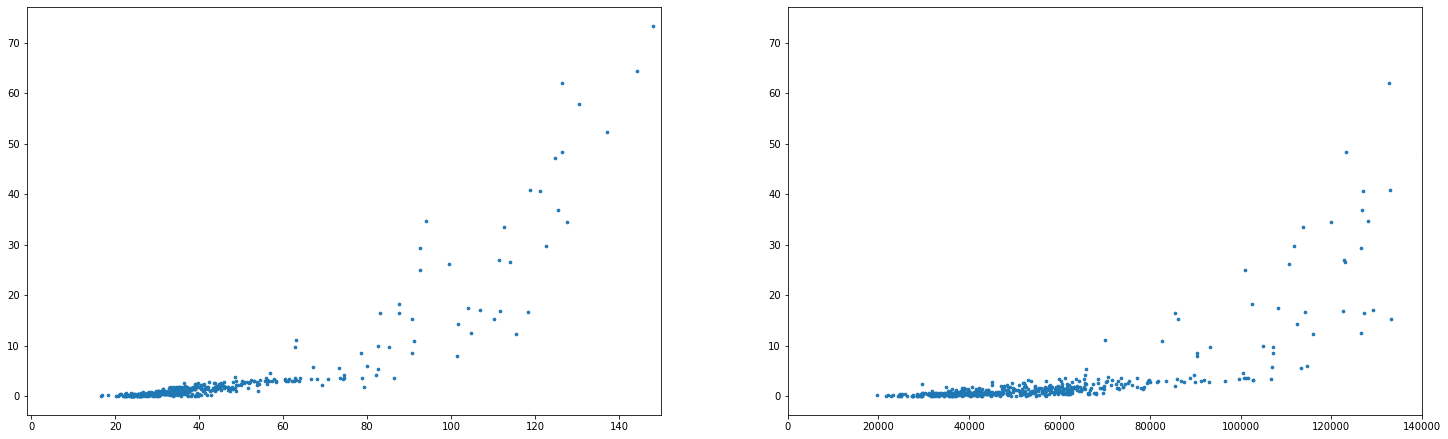

In [28]:
data = drop_outliers(data_2020_geo,z_score_filter=7)
data = data.loc[((data.PV_capacity_MW>0)&(data.PV_production_MWh>0)&(data.battery_capacity_MWh>0))]
fig,axes = plt.subplots(ncols=2,figsize=(25,7.5))
axes[0].scatter(data.PV_capacity_MW,data.battery_capacity_MWh,s=7)
axes[0].set_xlim(-1,150)
axes[1].scatter(data.PV_production_MWh,data.battery_capacity_MWh,s=7)
axes[1].set_xlim(-1,140000);


# 2050

In [11]:
results_path_2050 = '../../results/plant_optimization/0d7597c_2050'
countries = europe_grid.country.unique()
# countries = ['France']
results_2050 = pd.DataFrame()
for country in countries:
    df = pd.DataFrame()
    for file_glob in glob(f'{results_path_2050}/{country}*.csv'): 
        df = df.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df['sea_node'] = False
    df_sea = pd.DataFrame()
    for file_glob in glob(f'{results_path_2050}/offshore/{country}*.csv'): 
        df_sea = df_sea.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df_sea['sea_node'] = True
    df = df.append(df_sea)
    df['country'] = country
    results_2050 = results_2050.append(df)
data_2020_geo_2050 = gpd.GeoDataFrame(results_2050.merge(europe_grid,on=['lat','lon','country','sea_node'],how='left'))

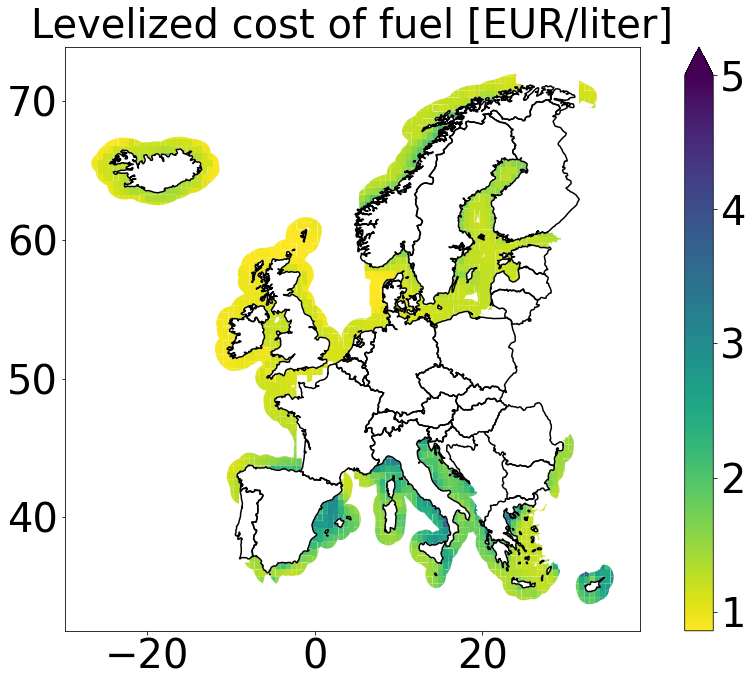

In [12]:
data = data_2020_geo_2050.copy()
# countries = ['Switzerland','Austria','Germany']
metrics = {'LCOF_liter':'Levelized cost of fuel [EUR/liter]'}
vmax_dict = {'LCOF_liter':5}
legend_kwds = {'extend':'max','orientation':'vertical'}
fontsize = 40
plot_results(data=data,countries=countries,metrics=metrics,vmax_dict=vmax_dict,legend_kwds=legend_kwds,figsize=(15,15),fontsize=fontsize)

2 Points reached the runtime limit
1 outlier entries were dropped.


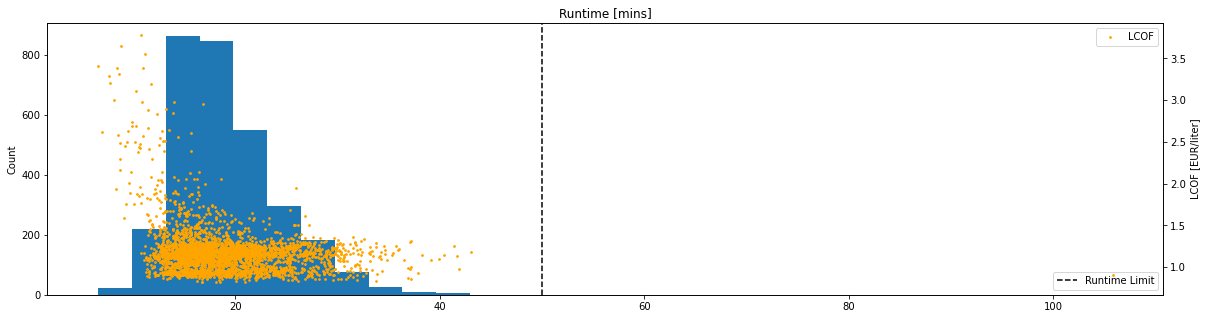

In [27]:
runtime_limit = 3000
print(len(data_2020_geo_2050.loc[data_2020_geo_2050.runtime>=runtime_limit]),'Points reached the runtime limit')

data = drop_outliers(data_2020_geo_2050,z_score_filter=7)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(20,5))
ax.hist(data.runtime/60,bins=30)
ax.axvline(runtime_limit/60,c ='k',linestyle='--',label='Runtime Limit') # Runtime limit
ax2 = plt.twinx(ax)
ax2.scatter(data.runtime/60,data.LCOF_liter,color='orange',s=3,label='LCOF');
ax.set_title('Runtime [mins]')
ax2.set_ylabel('LCOF [EUR/liter]')
ax2.legend(loc='upper right')
ax.legend(loc='lower right')
ax.set_ylabel('Count');

# 2030

In [11]:
results_path_2030 = os.path.join(results_path,'2030')
countries = europe_grid.country.unique()
# countries = ['France']
results_2030 = pd.DataFrame()
for country in countries:
    df = pd.DataFrame()
    for file_glob in glob(f'{results_path_2030}/{country}*.csv'): 
        df = df.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df['sea_node'] = False
    df_sea = pd.DataFrame()
    for file_glob in glob(f'{results_path_2030}/offshore/{country}*.csv'): 
        df_sea = df_sea.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df_sea['sea_node'] = True
    df = df.append(df_sea)
    df['country'] = country
    results_2030 = results_2030.append(df)
data_2020_geo_2030 = gpd.GeoDataFrame(results_2030.merge(europe_grid,on=['lat','lon','country','sea_node'],how='left'))

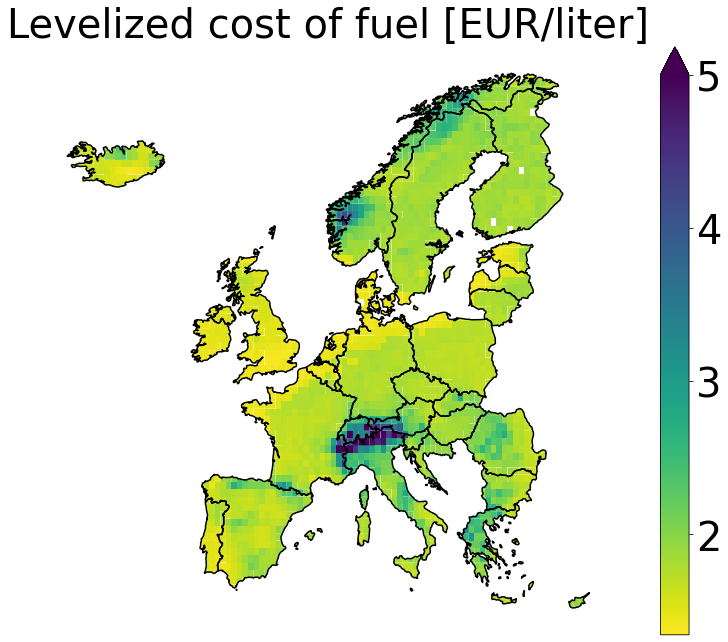

In [12]:
data = data_2020_geo_2030.copy()
# countries = ['Switzerland','Austria','Germany']
metrics = {'LCOF_liter':'Levelized cost of fuel [EUR/liter]'}
vmax_dict = {'LCOF_liter':5}
legend_kwds = {'extend':'max','orientation':'vertical'}
fontsize = 40
plot_results(data=data,countries=countries,metrics=metrics,vmax_dict=vmax_dict,legend_kwds=legend_kwds,figsize=(15,15),fontsize=fontsize)

0 Points reached the runtime limit
10 outlier entries were dropped.


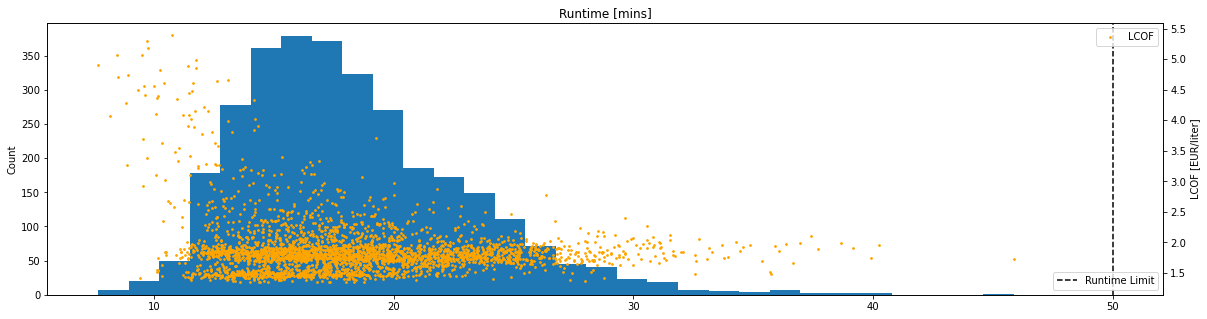

In [13]:
runtime_limit = 3000
print(len(data_2020_geo_2030.loc[data_2020_geo_2030.runtime>=runtime_limit]),'Points reached the runtime limit')

data = drop_outliers(data_2020_geo_2030,z_score_filter=7)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(20,5))
ax.hist(data.runtime/60,bins=30)
ax.axvline(runtime_limit/60,c ='k',linestyle='--',label='Runtime Limit') # Runtime limit
ax2 = plt.twinx(ax)
ax2.scatter(data.runtime/60,data.LCOF_liter,color='orange',s=3,label='LCOF');
ax.set_title('Runtime [mins]')
ax2.set_ylabel('LCOF [EUR/liter]')
ax2.legend(loc='upper right')
ax.legend(loc='lower right')
ax.set_ylabel('Count');

# Curtailed Electricity

1 outlier entries were dropped.


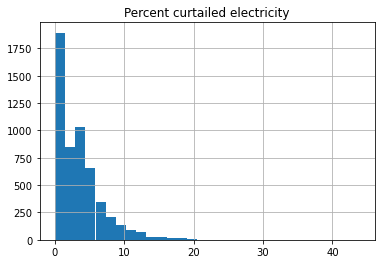

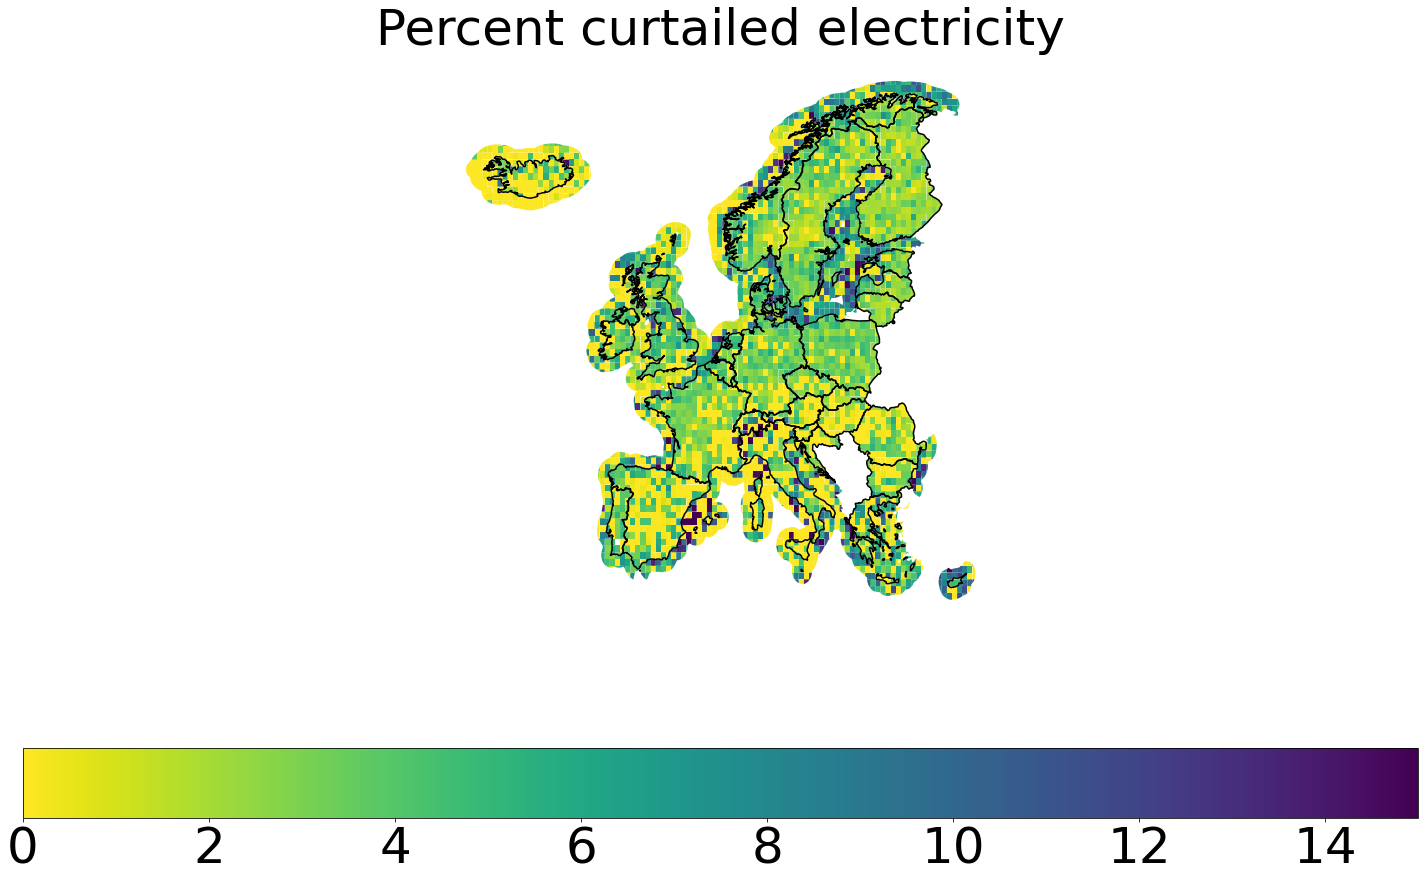

In [86]:
data = drop_outliers(data_2020_geo,z_score_filter==7)
data['percent_curtailed'] = data.curtailed_el_MWh/(data.PV_production_MWh+data.wind_production_MWh)*100
data.percent_curtailed.hist(bins=30)
plt.title('Percent curtailed electricity')

plot_results(data=data,countries=EU_EFTA,metrics={'percent_curtailed':'Percent curtailed electricity'},figsize=(25,15),ncols=None,fontsize=None,cmap=None,vmax_dict={'percent_curtailed':15},missing_kwds=None,legend_kwds={})

In [72]:
a = 'sasd asd'
a.split(' ')

['sasd', 'asd']

## Investigate high curtailed electricity

In [51]:
data_2020_geo.sort_values('curtailed_el_MWh',ascending=False).head(3)

,lat,lon,turbine_type,rotor_diameter,rated_turbine_power,wind_turbines,wind_capacity_MW,PV_capacity_MW,electrolyzer_capacity_MW,CO2_capture_tonph,...,PV_production_MWh,NPV_EUR,CAPEX_EUR,LCOF_MWh,LCOF_liter,runtime,country,PV_lat,PV_lon,geometry
50,47.5,10.625,N131/3300,131.0,3300.0,10.0,33.0,32.862530,14.276032,2.053427,...,26089.293703,1.317408e+08,8.061807e+07,804.649227,7.688870,1110.636494,Austria,47.390128,10.659047,"POLYGON ((10.93750 47.46889, 10.93750 47.25000..."
7,46.5,6.250,N131/3300,131.0,3300.0,7.0,23.1,23.527501,11.974207,1.221147,...,30478.994253,9.712394e+07,6.211337e+07,593.215669,5.668505,1008.013400,Switzerland,46.528093,6.329267,"POLYGON ((6.42015 46.75000, 6.56250 46.75000, ..."
6,46.0,10.000,GE120/2500,120.0,2500.0,9.0,22.5,148.706301,23.033372,2.207753,...,145623.739466,3.681098e+08,2.703777e+08,2248.348945,21.484223,432.779653,Switzerland,46.239057,10.098074,"POLYGON ((10.04078 46.25000, 10.15876 46.25000..."


In [62]:
country = 'Austria'
point = (47.5,10.625)
site = pop.Site(point,country)
plant = pop.Plant(site)
plant.operation = pd.read_parquet(f'../../results/02_plant_optimization/operation/{country}_{point[0]}_{point[1]}.parquet.gzip')
plant.operation.head()

,wind_production_kWh,PV_production_kWh,battery_chr_kWh,battery_dis_kWh,battery_state_kWh,H2stor_chr_kWh,H2stor_dis_kWh,H2stor_state_kWh,CO2stor_chr_kg,CO2stor_dis_kg,...,H2_el_kWh,CO2_el_kWh,H2tL_el_kWh,heat_el_kWh,battery_flow_kWh,H2_production_kWh,CO2_consumption_kg,CO2_production_kg,CO2stor_flow_kg,fuel_production_kWh
time,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:30:00,0.000000,0.0,0.0,254.831973,550.988050,9.995834e+06,1.000000e+07,69216.976394,9.999378e+06,1.000000e+07,...,0.000000,254.831973,0.0,0.0,-254.831973,0.000000,159891.75673,159269.983129,-621.7736,1221.395576
2016-01-01 01:30:00,0.000000,0.0,0.0,254.831973,275.494025,0.000000e+00,4.165566e+03,65051.410616,9.999378e+06,1.000000e+07,...,0.000000,254.831973,0.0,0.0,-254.831973,0.000000,159891.75673,159269.983129,-621.7736,1221.395576
2016-01-01 02:30:00,459.361453,0.0,0.0,0.000000,0.000000,0.000000e+00,4.042848e+03,60885.844838,9.999378e+06,1.000000e+07,...,204.529480,254.831973,0.0,0.0,0.000000,122.717688,159891.75673,159269.983129,-621.7736,1221.395576
2016-01-01 03:30:00,2076.424904,0.0,0.0,0.000000,0.000000,0.000000e+00,3.072610e+03,56842.996747,0.000000e+00,6.217736e+02,...,1821.592931,254.831973,0.0,0.0,0.000000,1092.955759,159891.75673,159269.983129,-621.7736,1221.395576
2016-01-01 04:30:00,4427.816467,0.0,0.0,0.000000,0.000000,9.998338e+06,1.000000e+07,53770.386728,0.000000e+00,6.217736e+02,...,4172.984494,254.831973,0.0,0.0,0.000000,2503.790697,159891.75673,159269.983129,-621.7736,1221.395576


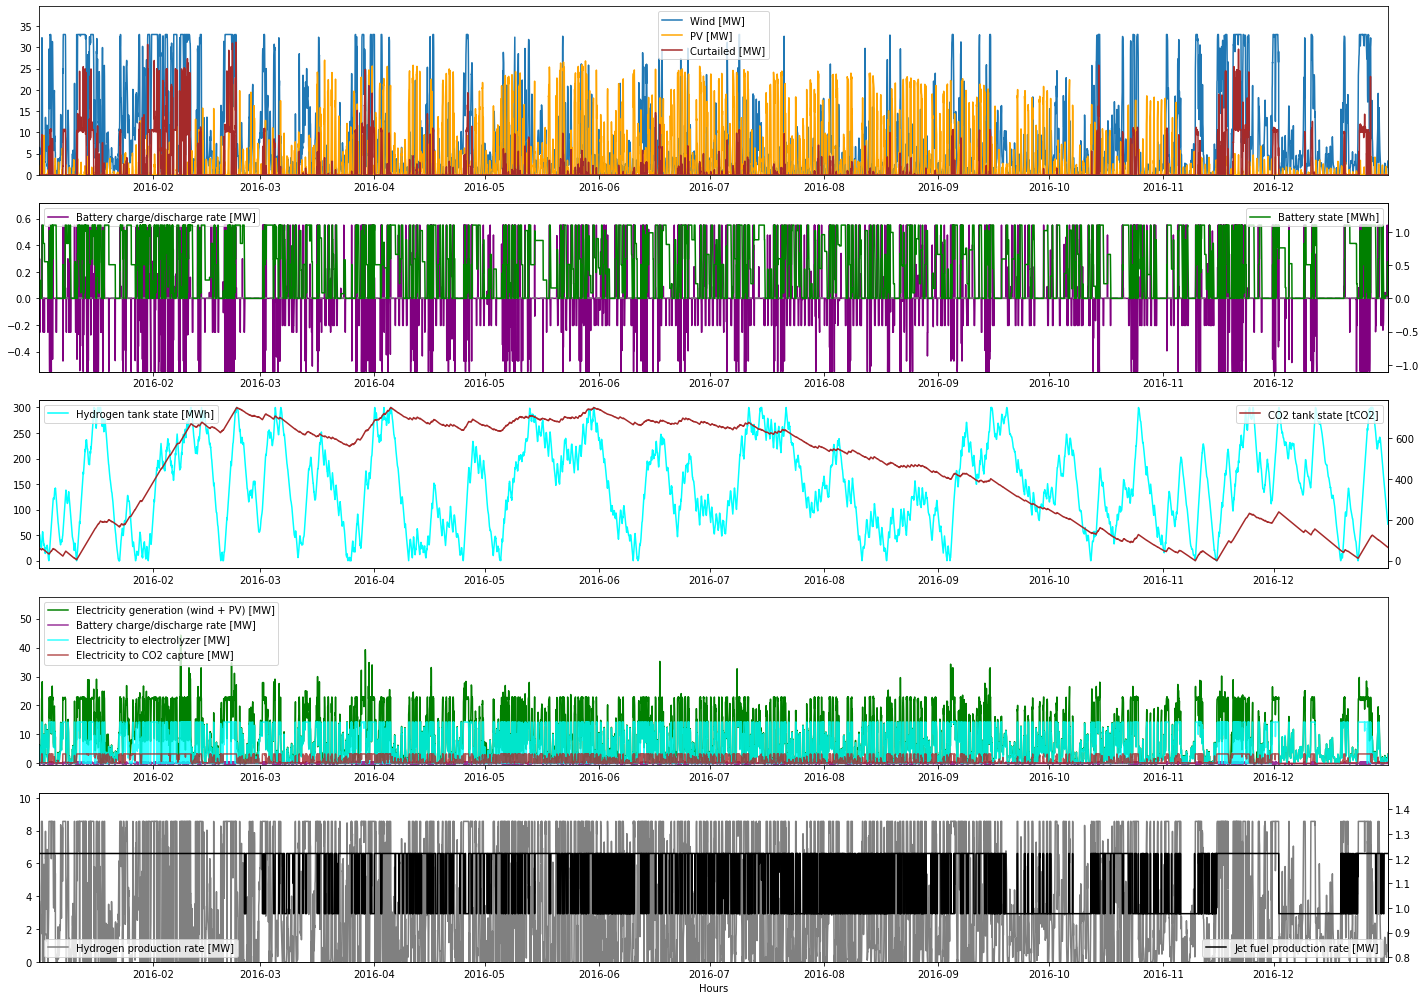

In [63]:
plot_plant_operation(plant)

AttributeError: 'DataFrame' object has no attribute 'site'

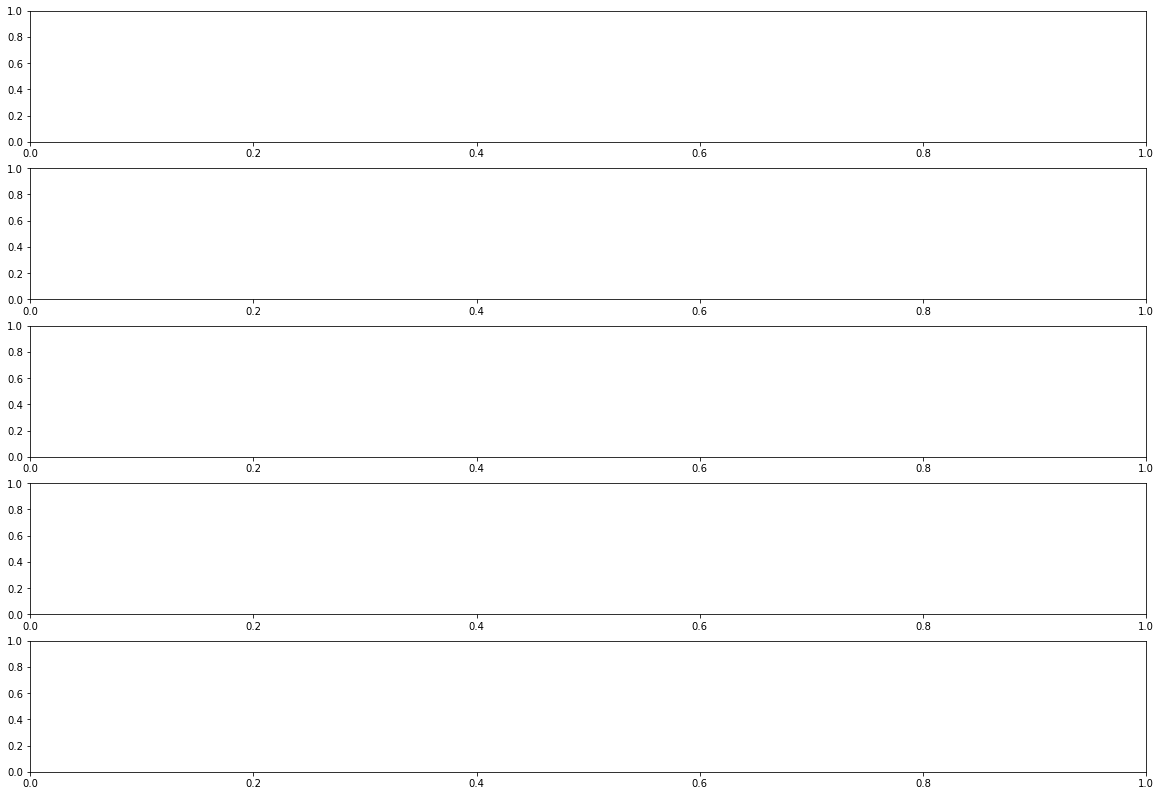

# Other

Wind only: 42.45%
PV only: 0.20%
Mixed:


,0
count,3091.000000
mean,1.450233
std,2.292544
min,0.024928
25%,0.657771
50%,0.884898
75%,1.499189
max,49.265490


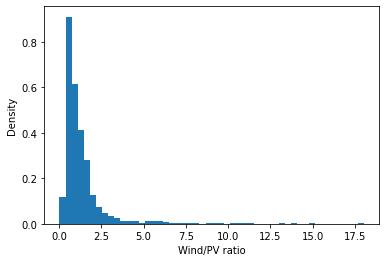

In [8]:
print(f'Wind only: {(data_2020.PV_capacity_MW==0).sum()/len(data_2020)*100:.2f}%')
print(f'PV only: {(data_2020.wind_capacity_MW==0).sum()/len(data_2020)*100:.2f}%')
temp = data_2020.loc[(data_2020.wind_capacity_MW!=0) & (data_2020.PV_capacity_MW!=0)].copy()
wind_pv_ratio = temp.wind_capacity_MW/temp.PV_capacity_MW
print('Mixed:')
display(pd.DataFrame(wind_pv_ratio.describe()))
wind_pv_ratio = wind_pv_ratio.loc[wind_pv_ratio<20]
plt.hist(wind_pv_ratio, bins=50, density=True)
plt.xlabel('Wind/PV ratio')
plt.ylabel('Density');